# QSR Competitive Meal Analysis Demo #

Welcome to part two of this this tutorial! Like the previous example, we'll explore how to use generative AI, specifically large language models (LLMs), to interact with a Quick Service Restaurant (QSR) menu stored in a SQL database with the same goal of enabling users to ask natural language questions about the menu (e.g., "What vegetarian options are there?", "What's the cheapest burger?") and receive informative answers.

This notebook demonstrates how to achieve this using **LangGraph**, a library built on LangChain designed for creating robust, stateful, and potentially cyclical AI agent applications. LangGraph allows for more fine-grained control over the agent's reasoning process compared to some simpler LangChain abstractions.

This tutorial assumes you have a good understanding of:
* Python programming
* Basic SQL concepts (SELECT queries, JOINs)
* The fundamentals of Large Language Models (LLMs)

We'll focus on explaining the LangGraph components and how they orchestrate the interaction between the LLM and the database.

## Install Dependencies

First, we need to ensure all the necessary Python libraries are installed. The code cell below handles this. 

In [13]:
try:
    import sqlalchemy
except ImportError:
    %pip install sqlalchemy -q
    import sqlalchemy

try:
    from langchain_openai import ChatOpenAI
except ImportError:
    %pip install langchain-openai -q
    from langchain_openai import ChatOpenAI

try:
    from IPython.display import Image, display
except ImportError:
    %pip install ipython -q
    from IPython.display import Image, display

try:
    # The main items you need from langchain_community
    from langchain_community.utilities import SQLDatabase
    from langchain_community.agent_toolkits import SQLDatabaseToolkit
except ImportError:
    %pip install langchain-community -q
    from langchain_community.utilities import SQLDatabase
    from langchain_community.agent_toolkits import SQLDatabaseToolkit

try:
    from langgraph.prebuilt import ToolNode
    from langgraph.graph import END, StateGraph
    from langgraph.graph.message import AnyMessage, add_messages
except ImportError:
    %pip install langgraph -q
    import langgraph
    from langgraph.prebuilt import ToolNode
    from langgraph.graph import END, StateGraph
    from langgraph.graph.message import AnyMessage, add_messages

try:
    from typing_extensions import TypedDict, Annotated
except ImportError:
    %pip install typing-extensions -q
    from typing_extensions import TypedDict, Annotated

# Now that they're installed/imported, bring in everything needed:

# Langchain Core
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import tool

# Pydantic & typing
from pydantic import BaseModel, Field
from typing import Literal, List, Sequence, Optional
import re

print("All libraries successfully imported and ready!")

All libraries successfully imported and ready!


## Setup Example Menu Database

Just like before, we'll create and populate an SQLite database from a JSON menu file, then wrap it in an SQLDatabase object to allow our agent to perform queries. This abstraction simplifies how the agent interacts with the database, allowing it to focus on generating the *correct* SQL rather than managing database connections.

In [2]:
from utils.qsr_db_builder import build_qsr_menu_database

# Build the SQLite database based on a JSON file in the data directory. Optionally, provide your own JSON file path.
engine = build_qsr_menu_database()

# Wrap engine in SQLDatabase
db = SQLDatabase(engine)

Database created and populated from ./data/menu.json


## Define Tools

With our database ready, we need to equip our agent with the **Tools** it can use to interact with the world (in this case, the database). In the previous example, we used the built in libraries in LangChain to provide the LLM with information about the tools it can use. While LangGraph gives us far more flexibility, it also means we have to define at least some of the tools we want the LLM to use.

### Preparing Agent Components: LLM and Tools

Before defining the LangGraph workflow itself, we need to configure the core components our agent will utilize: the LLM driver and the specific tools for database interaction. This cell sets up these building blocks.

1.  **LLM Initialization**: We instantiate our LLM using `ChatOpenAI`. 
    * The commented-out lines show how to connect to an NVIDIA NIM endpoint (replace `'your_api_key_here'` and the `model` name).
    * The active line shows how to connect to a local Ollama instance (replace the `base_url` if your Ollama runs elsewhere, and ensure the `model` name matches one you have downloaded). You might need to adjust the Ollama URL/model depending on your setup.
    * We set `temperature=0.0`. Temperature controls the randomness of the LLM's output. A value of 0 makes the output more deterministic and focused, which is generally preferred when generating structured output like SQL queries.

2.  **Standard SQL Tools**: We use LangChain's `SQLDatabaseToolkit`. This is a convenient way to get pre-built, standard tools for database interaction:
    * `sql_db_list_tables`: Allows the agent to ask for a list of all tables in the database.
    * `sql_db_schema`: Allows the agent to request the schema (columns, types, keys) for specific tables.
    These are essential for the agent to understand the database structure *before* trying to write queries. These are the same tools we used in the previous example.

3.  **Custom Query Execution Tool (`db_query_tool`)**: While the toolkit *could* provide a query execution tool, we define our own using the `@tool` decorator. 
    * **Why custom?** This gives us more control. Specifically, we use `db.run_no_throw(query)`. This method executes the SQL query but catches database errors (like syntax errors, invalid table/column names) and returns them as a string instead of crashing the Python process. This is vital for agent robustness – the agent can see the error and potentially correct its query.
    * The `@tool` decorator automatically handles input parsing and provides a description for the LLM to understand how to use the tool.

4.  **Robust Tool Execution (`create_tool_node_with_fallback`, `handle_tool_error`)**: 
    * In LangGraph, tools are typically executed within `ToolNode`s. However, if a tool function itself raises a Python exception (not a database error caught by `run_no_throw`), it could halt the graph.
    * To prevent this, we create a helper `create_tool_node_with_fallback`. This wraps the standard `ToolNode` with a fallback mechanism using `RunnableLambda(handle_tool_error)`.
    * The `handle_tool_error` function catches any exception during the tool's execution. It then formats the error message into a `ToolMessage` object.
    * **Why is this important?** By converting Python exceptions into `ToolMessage`s, the error becomes part of the graph's state (the list of messages). The LLM in the next step can then "see" the error message associated with its attempted tool call and try to recover (e.g., by fixing its arguments or trying a different approach). This makes the agent much more resilient.

These configured components – the LLM and the error-handling tool wrappers – are now ready to be assembled into our stateful LangGraph workflow in the following steps.

**Experimentation Idea:**
* Try switching between the NVIDIA and Ollama LLM options (if you have access to both) to see how the agent's behavior or SQL quality changes with different models.
* Look at the default tools provided by `SQLDatabaseToolkit`. Are there others you might want to include?

In [3]:
# Uncomment the following two lines to use the NVIDIA hosted model:
# api_key = "your_api_key_here"  # Replace with your actual API key from developer.nvidia.com
# llm = ChatOpenAI(base_url="https://integrate.api.nvidia.com/v1", model="meta/llama-3.3-70b-instruct", api_key=api_key, temperature=0.0)

# Use the line below to use the Ollama model running at ip address 192.168.1.23:
llm = ChatOpenAI(base_url="http://192.168.1.23:11434/v1", model="llama3.3:70b-instruct-q3_K_S", api_key="ollama", temperature=0.0)


# Create the SQLDatabaseToolkit with the database and LLM
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Identify the two default tools from the toolkit
list_tables_tool = next(t for t in tools if t.name == "sql_db_list_tables")
get_schema_tool = next(t for t in tools if t.name == "sql_db_schema")

@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database.
    Returns results or an error if the query fails.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return str(result)

def create_tool_node_with_fallback(tool_list):
    """
    Wrap a ToolNode with a fallback to surface errors to the agent.
    """
    return ToolNode(tool_list).with_fallbacks(
        [RunnableLambda(handle_tool_error)],
        exception_key="error",
    )

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


## Define LangGraph Workflow

This is the core of our tutorial, where we define the agent's structure and logic using LangGraph. LangGraph allows us to represent the agent's workflow as a **state machine** or **graph**. Each node in the graph represents a computation step (like calling the LLM or executing a tool), and edges represent the flow of control between these steps.

The workflow defined here includes several steps:
1.  **Agent Node**: Calls the LLM to decide the next action (get schema, generate SQL, provide final answer).
2.  **Tool Nodes**: Execute the database tools (`list_tables`, `get_schema`).
3.  **Checker Node**: A separate LLM call to validate and potentially correct the SQL generated by the main agent.
4.  **Query Execution Node**: Executes the (checked) SQL query.
5.  **Conditional Logic**: Routes the flow based on the agent's decisions or tool results.

This multi-step approach, particularly the inclusion of a dedicated SQL checker node, aims to improve the reliability of the SQL generation, especially when using less powerful LLMs. It adds intermediate checks and balances. While this does come at the cost of additional compute/tokens, when using the lower quality models that this tutorial uses, it is absolutely necessary. 

**Experimentation Idea:**
* As you go through the following cells, think about how you might simplify or change this workflow. Could the checker node be removed if using a more capable LLM? Could a reasoning model help here, or would it needlessly consume more tokens? Could you add more complex error handling or retry logic?

### Load Prompts & Define Final Answer Model

Before building the graph nodes, we need:

1.  **System Prompts**: These are instructions given to the LLM to guide its behavior within specific nodes.
    * `generic_system_instructions`: This prompt guides the main agent LLM (`sql_agent_node`). It tells the agent its goal (answer the user), the process to follow (discover schema -> plan SQL -> get results -> formulate answer), and *crucially*, instructs it to use specific tools (`sql_db_list_tables`, `sql_db_schema`) for discovery and the special `SubmitFinalAnswer` tool for its final response. Giving clear instructions and emphasizing the use of specific tools is key to effective agent behavior.
    * `checker_system_instructions`: This prompt is for the separate `query_checker` node. It instructs a (potentially the same) LLM to act as a SQL expert, validate a proposed query against the schema and question, correct it if necessary, and output *only* the final SQL string. This focused instruction helps ensure the checker node performs its specific task correctly.

2.  **Final Answer Tool Model (`SubmitFinalAnswer`)**: This is a Pydantic `BaseModel`. Defining a tool this way provides a structured format for the LLM's output.
    * **Why use a Pydantic model here?** By defining `SubmitFinalAnswer` with a specific field (`answer: str`), we tell the LLM *exactly* how it should structure its final response. The LangChain/LangGraph framework uses this model to instruct the LLM that when it's ready to provide the final answer, it should call this tool with the answer text in the `answer` argument.
    * This is more reliable than simply asking the LLM to "say the final answer". It provides a clear, machine-parseable signal that the agent considers its task complete, which we use later in our conditional logic (`decide_next_step`) to route to the `END` of the graph.

In [4]:
# Define the agent's system instructions and the checker system instructions

generic_system_instructions = """You are an expert SQL agent querying a SQLite database containing restaurant menu information.
Your **primary goal** is to provide a final, natural language answer to the user's question by calling the `SubmitFinalAnswer` tool.

Follow this process:
1.  **Analyze Question:** Understand the user's request and identify key criteria.
2.  **Discover Schema (If Needed):** Use `sql_db_list_tables` and `sql_db_schema` proactively to understand the database structure FIRST. Determine relevant tables and columns based on the discovered schema and the question. Call these tools if you don't have the information.
3.  **Plan & Generate SQL Query:** Based *only* on the schema you discovered via tools, plan and **output *only* the raw SQLite SQL query text** needed to get the data. Use JOINs and WHERE clauses correctly based on the discovered schema. Limit results appropriately.
4.  **Query Execution & Analysis:** Your generated query will be checked and then executed by the system. You will receive the results (data as a string) or an error message back.
5.  **Formulate Final Answer & CALL FINAL TOOL:** Analyze the query results or error. **You MUST now call `SubmitFinalAnswer`.**
    a.  **If you received data (and it's NOT empty '[]'):** Extract the key information. Formulate a **concise, natural language answer** addressing the original user question. **Call `SubmitFinalAnswer`** with this natural language answer.
    b.  **If you received empty results '[]':** Formulate a message stating *no results were found* (e.g., "No menu items matched your criteria based on the query ran.") and **call `SubmitFinalAnswer`** with that message. **DO NOT try to generate another query in this simplified flow.**
    c.  **If you received an error message:** Formulate a message explaining the problem (e.g., "I encountered a database error trying to execute the query: [error message]") and **call `SubmitFinalAnswer`** with that explanation. **DO NOT try to generate another query in this simplified flow.**

Tool Reminders:
- Use `sql_db_list_tables`/`sql_db_schema` for discovery FIRST.
- Output raw SQL for queries to be checked and executed.
- Use `SubmitFinalAnswer` for ALL final outputs (success, no results, or error). It is MANDATORY for finishing.
- Use valid SQLite. Do not make up info. No DML.
"""

checker_system_instructions = """You are an expert SQLite database engineer.
Given a database schema, a user question, and a proposed SQLite query, your task is to validate and correct the query.
1. Check the query for valid SQLite syntax.
2. Verify that all table names, column names, and join conditions used in the query are correct according to the provided schema. Pay close attention to column names used in JOIN ON clauses.
3. Ensure the query addresses the user's question appropriately.
4. Check for common mistakes (e.g., incorrect JOIN keys, missing filters, invalid functions).
5. **If the query is valid and correct:** Output the original query exactly.
6. **If the query is invalid or incorrect:** Output the corrected SQLite query.
7. **Output *only* the final, valid SQLite query string.** Do not add any other text, explanations, or markdown formatting (like ```sql ... ```).
"""

# Pydantic model for the agent's final output tool.
class SubmitFinalAnswer(BaseModel):
    """Call this tool to submit the final answer to the user."""
    answer: str = Field(..., description="The final answer to the user based on the query results.")

### State Definition & Graph Initialization

LangGraph workflows are **stateful**. This means information is carried and updated as the execution moves between nodes. We need to define the structure of this state.

1.  **`State` Definition**: We define a `State` class using `TypedDict`. This acts like a Python dictionary but with defined keys and value types, providing better code completion and type checking.
    * `messages: Annotated[List[AnyMessage], add_messages]`: This is the most important part of our state. It holds the history of the interaction.
        * `List[AnyMessage]`: Specifies that `messages` will be a list containing various types of LangChain messages (`HumanMessage`, `AIMessage`, `ToolMessage`).
        * `Annotated[..., add_messages]`: This is a special LangGraph annotation. `add_messages` tells LangGraph how to update this part of the state. Instead of replacing the `messages` list entirely, each node's output messages will be *appended* to the existing list. This preserves the conversation history, which is crucial for the LLM agent to have context.
    * We could add other fields to the `State` if our agent needed to track different pieces of information across steps (e.g., `retries_left: int`).

2.  **Graph Initialization**: `workflow = StateGraph(State)` creates an instance of our graph. We pass our `State` definition to it, so the graph knows the structure of the data it will manage.

Think of the `State` as a shared dictionary that each node can read from and write to (specifically, by returning updates). The `messages` list is the primary way information flows in this agent.

In [5]:
# --- State Definition ---
# Defines the structure of information passed between nodes in the graph.
class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    # Add other state variables if needed

# --- Graph Initialization ---
workflow = StateGraph(State)
print("State defined and workflow initialized.")

State defined and workflow initialized.


### Tool Node Definitions

Now we add nodes to our graph that are specifically designed to execute tools.

1.  **`create_tool_node_with_fallback(...)`**: We use the helper function defined earlier to wrap our tool functions (`list_tables_tool`, `get_schema_tool`, `db_query_tool`). This creates instances of LangGraph's `ToolNode`, pre-configured with our error-handling logic.
    * `ToolNode` is specifically designed to take an incoming `AIMessage` containing tool calls, execute the corresponding tool(s), and return the results as `ToolMessage`s.

2.  **`workflow.add_node("node_name", node_object)`**: This method registers each tool-executing node with our `workflow`.
    * `"list_tables_tool"`, `"get_schema_tool"`, `"execute_db_query"`: These are the unique string names we assign to these nodes within the graph. We'll use these names when defining the edges (connections) between nodes.
    * `list_tables_node`, `schema_node`, `db_query_node`: These are the actual `ToolNode` objects (with fallbacks) created in the previous step.

Note that the `db_query_node` is intended to execute the SQL query *after* it has passed through the `query_checker` node. The main agent (`sql_agent_node`) won't directly call this execution node; instead, the `query_checker` node will format its output to trigger this node.

In [6]:
# --- Tool Execution Nodes ---
# Wrap tool functions for graph execution.

list_tables_node = create_tool_node_with_fallback([list_tables_tool])
workflow.add_node("list_tables_tool", list_tables_node)

schema_node = create_tool_node_with_fallback([get_schema_tool])
workflow.add_node("get_schema_tool", schema_node)

# This node executes the SQL query *after* it has been checked.
db_query_node = create_tool_node_with_fallback([db_query_tool])
workflow.add_node("execute_db_query", db_query_node)

print("Tool execution nodes defined and added to workflow.")

Tool execution nodes defined and added to workflow.


### SQL Agent Node Definition

This node represents the "brain" of our operation. It's where the primary LLM call happens to decide the course of action.

1.  **Prompt (`sql_prompt`)**: We create a `ChatPromptTemplate` using the `generic_system_instructions` defined earlier. The `("placeholder", "{messages}")` part is crucial – it tells the template to insert the entire message history from the current `State` when formatting the prompt for the LLM.

2.  **Agent Tools (`llm_agent_tools`)**: We define the list of tools that *this specific agent node* is allowed to directly invoke:
    * `SubmitFinalAnswer`: The Pydantic model for signalling the final answer.
    * `list_tables_tool`: The tool to list database tables.
    * `get_schema_tool`: The tool to get table schemas.
    * **Note:** We do *not* include `db_query_tool` here. Our workflow design dictates that the agent should generate SQL as text, which then goes to the `query_checker` node. Only the checker node's output will trigger the actual `execute_db_query` node.

3.  **Binding Tools (`llm_with_agent_tools`)**: `llm.bind_tools(llm_agent_tools)` attaches the specified tools to the LLM instance. This modifies the LLM's API call to inform it about the available tools and their schemas (including the Pydantic model `SubmitFinalAnswer`), enabling it to generate structured tool-calling requests when appropriate.

4.  **Agent Chain (`sql_agent_chain`)**: We create a simple LangChain Runnable sequence (`sql_prompt | llm_with_agent_tools`). This takes the input messages, formats them using the prompt, sends them to the LLM (which now knows about the tools), and receives the LLM's response (which could be text content or a tool call request).

5.  **Node Function (`sql_agent_node`)**: This function defines the actual logic for the node within the LangGraph workflow.
    * It takes the current `State` as input.
    * It prints the incoming messages for debugging (useful to see what the LLM is seeing).
    * It invokes the `sql_agent_chain` with the messages from the state.
    * It returns the LLM's response (`AIMessage`) wrapped in a dictionary `{"messages": [response]}`. Because our state's `messages` field uses `add_messages`, this new `AIMessage` will be appended to the history in the state.
    * Includes basic error handling for the LLM call itself.

6.  **Add Node (`workflow.add_node`)**: We register this function as the `"sql_generation"` node in our graph.

This node acts as the central decision-maker, using the conversation history and its allowed tools to decide whether to gather more information (list tables, get schema), attempt to generate SQL (as text content), or conclude the process (`SubmitFinalAnswer`).

In [7]:
# --- Agent Components: Prompt, Tools, Chain ---
sql_prompt = ChatPromptTemplate.from_messages(
    [("system", generic_system_instructions), ("placeholder", "{messages}")]
)

# Tools the main agent LLM can directly invoke.
llm_agent_tools = [
    SubmitFinalAnswer,
    list_tables_tool,
    get_schema_tool
]
# Assumes llm object has bind_tools method
llm_with_agent_tools = llm.bind_tools(llm_agent_tools)

# Runnable chain for the main agent LLM.
sql_agent_chain = sql_prompt | llm_with_agent_tools

# --- Graph Node Function: SQL Agent ---
def sql_agent_node(state: State):
    """Invokes the main LLM agent to decide the next step or generate SQL."""
    print("--- Running Node: sql_agent_node (LLM) ---")
    print("--- Messages being sent to agent: ---")
    for msg in state["messages"]:
        print(f"  {type(msg).__name__}: {getattr(msg, 'content', '')[:200]} {getattr(msg, 'tool_calls', '')}")
    print("------------------------------------")
    try:
        response = sql_agent_chain.invoke({"messages": state["messages"]})
        # The response is an AIMessage potentially containing content or tool calls.
        return {"messages": [response]}
    except Exception as e:
        print(f"\n!!! Error during sql_agent_chain.invoke: {type(e).__name__}: {e}")
        error_content = f"Error during LLM agent invocation: {type(e).__name__}: {e}"
        return {"messages": [AIMessage(content=error_content)]}

# Add node to workflow
workflow.add_node("sql_generation", sql_agent_node)
print("SQL Agent node defined and added to workflow.")

SQL Agent node defined and added to workflow.


### SQL Checker Node Definition

This node adds a layer of validation to the workflow. When the main agent (`sql_generation`) produces raw SQL text, we route it here first before execution.

**Rationale:** LLMs can sometimes make mistakes when generating SQL (e.g., incorrect syntax, hallucinating column names, incorrect JOINs). Adding a dedicated checker step, guided by a specific prompt, can catch and correct these errors before they hit the database, improving overall reliability.

1.  **Checker Prompt (`checker_prompt`)**: Uses the `checker_system_instructions`. It's designed to take the schema, original question, and the proposed SQL as input.

2.  **Checker Chain (`checker_chain`)**: A simple chain combining the `checker_prompt` and the LLM. We can use the same LLM as the main agent, but its behavior will be governed by the different system prompt.

3.  **Helper Functions (`find_last_sql_query`, `find_last_schema`, `find_question`)**:
    * **Why are these needed?** The checker node needs specific pieces of information (the proposed query, the schema the agent used, the original question) to do its job. This information exists within the `messages` list in the `State`, but it might be buried among many other messages (tool calls, tool results, previous agent thoughts).
    * These functions search backwards through the `messages` list to find the most recent relevant piece of information: the last raw SQL query generated by the agent, the last schema provided by a `ToolMessage`, and the initial `HumanMessage`.
    * Using helper functions makes the main node logic cleaner.

4.  **Node Function (`check_sql_query_node`)**: 
    * Takes the current `State`.
    * Uses the helper functions to extract the `proposed_query`, `schema`, and `question` from the `messages` history.
    * Handles cases where necessary information might be missing.
    * Invokes the `checker_chain` with the extracted information.
    * **Crucially**, it takes the response from the checker LLM (which should be *only* the validated/corrected SQL string) and formats it as an `AIMessage` that contains a *tool call* to our `db_query_tool`.
    * **Why format as a tool call?** This is how we trigger the *next* node in the graph (`execute_db_query`). The `decide_next_step` logic (which we'll define soon) will see this `AIMessage` with a `db_query_tool` call and route execution to the corresponding `ToolNode`.
    * Returns the new `AIMessage` containing the tool call to be added to the state.

5.  **Add Node (`workflow.add_node`)**: Registers this function as the `"query_checker"` node.

This node acts as an intermediary validation step, taking raw SQL from one node, using an LLM to refine it, and packaging the result to trigger the *actual* database query execution node.

In [8]:
# --- SQL Query Checker Components ---
checker_prompt = ChatPromptTemplate.from_messages([
    ("system", checker_system_instructions),
    ("user", "Here is the database schema:\n\n{schema}\n\nHere is the original user question:\n\n{question}\n\nHere is the proposed query:\n\n{query}\n\nPlease validate or correct the query and output only the final SQL string.")
])

# Runnable chain for the checker. Can use the same or a different LLM.
checker_chain = checker_prompt | llm

# --- Helper Functions for State Extraction ---
def find_last_sql_query(messages: Sequence[AnyMessage]) -> Optional[str]:
    """Extracts the most recent raw SQL query content from agent AIMessages."""
    for msg in reversed(messages):
        if isinstance(msg, AIMessage) and msg.content:
            # Simple regex to check if content looks like a SQL SELECT or WITH statement
            # Ignores potential markdown backticks
            match = re.search(r"^\s*(?:```sql\s*)?(SELECT|WITH)\b", msg.content, re.IGNORECASE | re.DOTALL)
            if match:
                # Strip markdown if present
                sql_content = re.sub(r"^\s*```sql\s*", "", msg.content)
                sql_content = re.sub(r"\s*```\s*$", "", sql_content)
                return sql_content.strip()
    return None

def find_last_schema(messages: Sequence[AnyMessage]) -> Optional[str]:
    """Extracts the most recent database schema string from ToolMessages."""
    for msg in reversed(messages):
        # Check if it's a ToolMessage, has content, isn't an error, and contains 'create table'
        if (isinstance(msg, ToolMessage) and
            msg.content and
            "error" not in msg.content.lower() and
            "create table" in msg.content.lower()):
            return msg.content
    return None

def find_question(messages: Sequence[AnyMessage]) -> Optional[str]:
    """Finds the content of the first HumanMessage (the user's query)."""
    for msg in messages:
        if isinstance(msg, HumanMessage):
            return msg.content
    return None

# --- Graph Node Function: SQL Query Checker ---
def check_sql_query_node(state: State):
    """Validates/corrects the SQL query generated by the agent using the checker chain."""
    print("--- Running Node: query_checker ---")
    messages = state['messages']

    proposed_query = find_last_sql_query(messages)
    schema = find_last_schema(messages)
    question = find_question(messages)

    if not proposed_query:
        print("Query Checker Error: Could not find proposed SQL query.")
        # Return an error message to the agent so it knows something went wrong
        return {"messages": [AIMessage(content="Internal Error: No SQL query found to check.")]}
    if not schema:
        print("Query Checker Error: Could not find database schema.")
        # Ask the agent to fetch the schema again
        return {"messages": [AIMessage(content="Internal Error: Database schema not found to check query against. Please use schema discovery tools first.")]}
    if not question:
        print("Query Checker Error: Could not find original question.")
        return {"messages": [AIMessage(content="Internal Error: Original question not found.")]}

    print(f"Checking Query: {proposed_query[:100]}...")
    try:
        checked_sql_response = checker_chain.invoke({
            "schema": schema,
            "question": question,
            "query": proposed_query
        })
        # Assuming the checker LLM outputs *only* the SQL string
        checked_sql_string = checked_sql_response.content.strip()
        # Basic check if the output is likely SQL
        if not re.match(r"^(SELECT|WITH)", checked_sql_string, re.IGNORECASE):
             print(f"Checker did not return valid SQL. Output: {checked_sql_string[:100]}...")
             # Return the checker's potentially conversational output back to the main agent for review
             return {"messages": [AIMessage(content=f"SQL Checker Response: {checked_sql_string}")]}

        print(f"Checked Query Result: {checked_sql_string[:100]}...")

        # Format the output to call the actual query execution tool.
        tool_call_id = f"checked_db_query_{len(messages)}" # Generate a unique ID
        checked_sql_tool_call = AIMessage(
            content="", # No conversational content needed, just the tool call
            tool_calls=[{
                "name": db_query_tool.name, # Target the db_query_tool
                "args": {"query": checked_sql_string}, # Pass the checked SQL as argument
                "id": tool_call_id
            }],
        )
        return {"messages": [checked_sql_tool_call]}

    except Exception as e:
        print(f"\n!!! Error during checker_chain.invoke: {type(e).__name__}: {e}")
        error_content = f"Error during SQL check phase: {type(e).__name__}: {e}"
        # Return error back to the main agent
        return {"messages": [AIMessage(content=error_content)]}

# Add node to workflow
workflow.add_node("query_checker", check_sql_query_node)
print("SQL Checker node and helpers defined and added to workflow.")

SQL Checker node and helpers defined and added to workflow.


### Conditional Logic Function

This function, `decide_next_step`, is the router of our agent. After the main `sql_generation` node runs (or potentially after the `query_checker` node runs), this function is called to determine where the workflow should go next.

1.  **Input**: Takes the current `State`.
2.  **Inspect Last Message**: It examines the *most recent* message added to the `state["messages"]` list. The type and content of this last message dictate the next action.
3.  **Routing Logic**: 
    * **If the last message is a `ToolMessage`**: This means a tool just ran (e.g., `list_tables_tool` or `execute_db_query`). The results are now in the `ToolMessage`. We should send this information back to the main agent (`sql_generation`) so it can process the results and decide what to do next. -> Return `"sql_generation"`.
    * **If the last message is an `AIMessage`**: This means the main agent (`sql_generation`) or the checker (`query_checker`) just ran. We need to look *inside* this `AIMessage`:
        * **Does it contain `tool_calls`?**
            * If the tool call is for `SubmitFinalAnswer`: The agent has decided it's finished. -> Return `END` (a special LangGraph marker to terminate the workflow).
            * If the tool call is for `list_tables_tool`: Route to the node that executes this tool. -> Return `"list_tables_tool"`.
            * If the tool call is for `get_schema_tool`: Route to the node that executes this tool. -> Return `"get_schema_tool"`.
            * If the tool call is for `db_query_tool` (this call comes from the `query_checker` node): Route to the node that executes the database query. -> Return `"execute_db_query"`.
            * If it's an unknown tool call: Route back to the main agent as a fallback. -> Return `"sql_generation"`.
        * **Does it contain `content` but no `tool_calls`?**
            * If the content looks like SQL (using `find_last_sql_query`): The agent generated SQL text. Route it to the checker. -> Return `"query_checker"`.
            * If the content is *not* SQL (e.g., an error message from the checker, a clarification): Route back to the main agent (`sql_generation`) to process this text content and decide the next step (which might be to call `SubmitFinalAnswer` or try again). -> Return `"sql_generation"`.
        * **Is it an empty `AIMessage`?** This shouldn't usually happen, but if it does, route back to the agent to retry. -> Return `"sql_generation"`.
    * **Fallback**: If the last message is of an unexpected type (like the initial `HumanMessage`), route to the main agent. -> Return `"sql_generation"`.

4.  **Output**: The function returns a string which is the **name** of the *next node* to execute, or the special `END` marker.

This conditional logic is essential for creating dynamic, multi-step agent behavior. It allows the graph to react differently based on the LLM's output and the results of tool executions.

In [9]:
# --- Conditional Logic ---
def decide_next_step(state: State) -> Literal[
    "list_tables_tool", "get_schema_tool", "query_checker", "execute_db_query", "sql_generation", END
]:
    """Determines the next node to execute based on the last message."""
    print("--- Running Node: decide_next_step ---")
    last_message = state["messages"][-1]
    print(f"Decision based on last message type: {type(last_message).__name__}")

    # If the previous step was a tool execution, send results back to the main agent
    if isinstance(last_message, ToolMessage):
        print(f"Routing: ToolMessage ({getattr(last_message, 'tool_call_id', 'N/A')}) -> sql_generation")
        return "sql_generation"

    if isinstance(last_message, AIMessage):
        if last_message.tool_calls:
            # Check the requested tool names
            tool_call = last_message.tool_calls[0]
            tool_name = tool_call["name"]

            if tool_name == SubmitFinalAnswer.__name__:
                print("Routing: SubmitFinalAnswer requested -> END")
                return END
            elif tool_name == list_tables_tool.name:
                print(f"Routing: {list_tables_tool.name} requested -> list_tables_tool")
                return "list_tables_tool"
            elif tool_name == get_schema_tool.name:
                print(f"Routing: {get_schema_tool.name} requested -> get_schema_tool")
                return "get_schema_tool"
            elif tool_name == db_query_tool.name:
                # This specific tool call originates *only* from the query_checker node
                print(f"Routing: AIMessage tool call for {db_query_tool.name} (from checker) -> execute_db_query")
                return "execute_db_query"
            else:
                # Agent requested a tool it shouldn't have or an unknown tool
                print(f"Warning: Agent requested unhandled/unexpected tool: {tool_name} -> sql_generation")
                # Route back to the agent to potentially correct itself
                return "sql_generation"

        elif last_message.content:
            # If the AIMessage has content but no tool calls, check if it's SQL
            potential_sql = find_last_sql_query([last_message])
            if potential_sql:
                # This content came from the main 'sql_generation' node
                print("Routing: AIMessage contains SQL -> query_checker")
                return "query_checker"
            else:
                # Content is not SQL (e.g., an error message from checker, or agent is just talking)
                # Route back to the main agent to process the text content
                print("Routing: AIMessage non-SQL content (or error msg) -> sql_generation (Agent should process)")
                return "sql_generation"
        else:
             # Empty AIMessage (no tool calls, no content)
            print("Routing: Empty AIMessage -> sql_generation (Attempt recovery)")
            return "sql_generation"

    # Fallback for any other state (e.g., starting with HumanMessage)
    print(f"Routing: Fallback (last msg type: {type(last_message).__name__}) -> sql_generation")
    # Typically, the flow starts here after the initial HumanMessage
    return "sql_generation"

print("Conditional logic function 'decide_next_step' defined.")

Conditional logic function 'decide_next_step' defined.


### Define Graph Edges & Compile

We've defined our nodes (computational units) and the conditional logic for routing. Now, we connect everything together by defining the edges of the graph.

1.  **Entry Point (`workflow.set_entry_point(...)`):**
    * We explicitly tell LangGraph which node should run first when the graph is invoked. In our case, it's the main agent node, `"sql_generation"`.

2.  **Direct Edges (`workflow.add_edge(source, destination)`):**
    * `workflow.add_edge("list_tables_tool", "sql_generation")`
    * `workflow.add_edge("get_schema_tool", "sql_generation")`
    * `workflow.add_edge("execute_db_query", "sql_generation")`:
        These edges define fixed transitions. After any of these tool nodes execute, the results (as a `ToolMessage`) should always be sent back to the `"sql_generation"` node for the agent to process. The conditional logic function `decide_next_step` will be called *after* the `ToolMessage` is added to the state, confirming this transition.

3.  **Conditional Edges (`workflow.add_conditional_edges(...)`):**
    * We define conditional edges originating from two nodes: `"sql_generation"` (the main agent) and `"query_checker"` (the SQL validator).
    * **Source Node:** The first argument specifies *which node's output* triggers the condition (`"sql_generation"` or `"query_checker"`).
    * **Condition Function:** The second argument is our `decide_next_step` function. LangGraph calls this function after the source node runs, passing it the current state.
    * **Path Map:** The third argument is a dictionary mapping the *string output* of `decide_next_step` to the *name of the next node* to execute.
        * Example 1: If `sql_generation` outputs an `AIMessage` containing SQL, `decide_next_step` returns `"query_checker"`. The graph then transitions to the `"query_checker"` node.
        * Example 2: If `query_checker` outputs an `AIMessage` containing a tool call for `db_query_tool`, `decide_next_step` returns `"execute_db_query"`. The graph then transitions to the `"execute_db_query"` node.
        * Example 3: If `sql_generation` outputs an `AIMessage` calling `SubmitFinalAnswer`, `decide_next_step` returns `END`. The graph terminates.
    * By defining conditional edges for both agent nodes, we allow the graph to dynamically route based on the output of either LLM call.

4.  **Compile (`app = workflow.compile()`):**
    * This finalizes the graph definition, checks for inconsistencies (like dangling nodes), and returns a runnable `CompiledGraph` object (which we assign to `app`).
    * This `app` object is what we will use to actually execute the agent workflow.

We have now fully defined the structure and logic of our LangGraph agent!

In [10]:
# --- Define Graph Edges ---
print("Defining graph edges...")

# Entry point: Start with the SQL generation agent
workflow.set_entry_point("sql_generation") # Explicitly set the entry point

# Edges from tool execution nodes back to the agent
# After a tool runs, its result (ToolMessage) goes to the agent node's input.
workflow.add_edge("list_tables_tool", "sql_generation")
workflow.add_edge("get_schema_tool", "sql_generation")
workflow.add_edge("execute_db_query", "sql_generation")

# Conditional routing AFTER the main agent acts
# Based on the AIMessage from sql_generation, route to a tool, the checker, or end.
workflow.add_conditional_edges(
    "sql_generation", # Source node
    decide_next_step, # Function to determine the route
    { # Map decision outcome to the next node name
        "list_tables_tool": "list_tables_tool",
        "get_schema_tool": "get_schema_tool",
        "query_checker": "query_checker", # Route to checker if agent produced SQL
        "execute_db_query": "execute_db_query", # Should not happen directly from sql_generation in this setup
        "sql_generation": "sql_generation", # Route back if tool result added or non-SQL content needs processing
        END: END # End if SubmitFinalAnswer is called
    }
)

# Conditional routing AFTER the checker acts
# Based on the AIMessage from query_checker, route to execute the query or back to the agent.
workflow.add_conditional_edges(
    "query_checker", # Source node is the checker
    decide_next_step, # Use the SAME routing logic
    { # Map decision outcome based on checker's output
        "list_tables_tool": "list_tables_tool", # Should not happen from checker
        "get_schema_tool": "get_schema_tool", # Should not happen from checker
        "query_checker": "query_checker", # Should not loop back directly without agent
        "execute_db_query": "execute_db_query", # Route to execution if checker produced ToolCall
        "sql_generation": "sql_generation", # Route back to agent if checker produced text/error
        END: END # End if checker somehow decided to end (unlikely)
    }
)

# --- Compile the graph ---
print("Compiling the graph...")
app = workflow.compile()

print("\nLangGraph workflow compiled successfully!")

Defining graph edges...
Compiling the graph...

LangGraph workflow compiled successfully!


## Visualize the Workflow

Graphs, especially those with conditional logic, can become complex. LangGraph provides a handy way to visualize the compiled graph structure.

The code below calls `app.get_graph().draw_mermaid_png()`. This generates a diagram of our workflow using the Mermaid diagramming syntax and returns it as PNG image data.

We then use `IPython.display.Image` and `display` to show this image directly in the notebook. In the diagram, solid lines signify the path will always execute where a dashed line signifies a conditional path.

This visualization helps confirm:
* All nodes are present.
* The entry point (`START` implicitly connects to `sql_generation`) is connected correctly.
* Edges between nodes reflect our intended logic (both direct and conditional).
* Potential termination points (`END`) are reachable.

Examine the diagram to trace the possible paths the agent can take based on its decisions and tool outcomes.

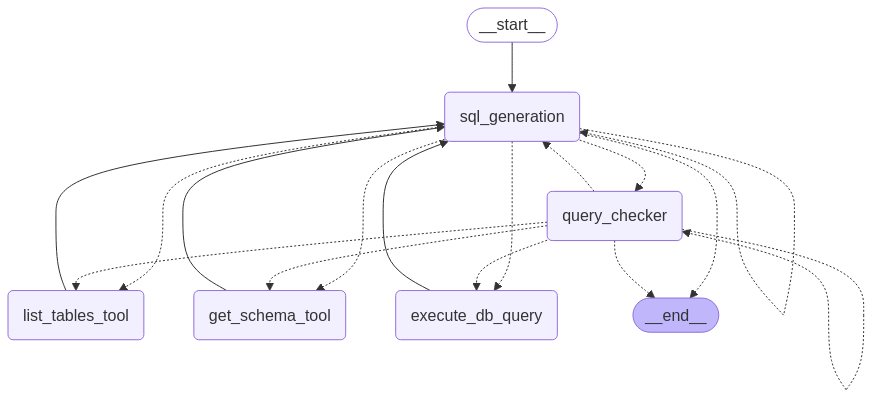

In [ ]:
try:
    png_data = app.get_graph().draw_mermaid_png()
    display(Image(png_data))
except Exception as e:
    print(f"An error occurred while generating the visualization: {e}")

## Invoke Graph and Display Final Answer

Now it's time to run our compiled LangGraph application (`app`)!

1.  **Helper Function (`extract_final_response`)**: We import a utility function from `utils/result_utils.py`. This function takes the final state dictionary returned by the graph and the name of our final answer tool (`SubmitFinalAnswer.__name__`) and searches through the message history to find the specific `ToolMessage` that corresponds to the successful call of `SubmitFinalAnswer`, extracting the actual answer content.

2.  **User Question**: Define the natural language question you want to ask the agent.

3.  **Initial Input**: Prepare the input for the graph. LangGraph applications expect the input to match the structure of the `State` they were defined with. Since our state's primary component is `messages`, we format the input as a dictionary `{"messages": [HumanMessage(content=user_question)]}`. This places the user's question as the first message in the state, kicking off the process.

4.  **Invoke Graph (`app.invoke(initial_input)`)**: This is where the magic happens! We call the `invoke` method on our compiled graph (`app`), passing the initial input. LangGraph then executes the workflow:
    * Starts at the entry node (`sql_generation`).
    * Passes the state between nodes.
    * Calls the appropriate node functions (LLM agents, tool executors).
    * Uses the conditional logic (`decide_next_step`) to route execution.
    * Continues until a node routes to `END`.
    * The `invoke` method returns the **final state** of the graph after execution finishes (a dictionary containing the complete `messages` list and any other state variables).

5.  **Extract and Display**: We pass the `result` (the final state dictionary) to our `extract_final_response` helper function to get the clean answer provided by the agent via the `SubmitFinalAnswer` tool. Finally, we print this answer.

**Experimentation Idea:**
* Change the `user_question` to something else! Try simple questions ("How many items on the menu?"), more complex ones ("What are the side dishes under $3?"), or questions that might require JOINS ("What category is the 'Classic Burger' in?").
* Observe the `print` statements from the nodes during execution. Can you follow the agent's reasoning process? Where does it use tools? Does the checker modify the SQL?
* Introduce deliberate errors (e.g., ask about a non-existent column) to see how the agent and error handling respond.

In [14]:
# Import the helper function from the separate file
from utils.result_utils import extract_final_response

# --- Define the User Question ---
user_question = "What is the healthiest meal (not Drink) on the menu?"
# user_question = "Which menu items are vegetarian?"
# user_question = "List all burgers and their prices."
# user_question = "What drinks cost less than $2.00?"

# --- Prepare Input for the Graph ---
initial_input = {"messages": [HumanMessage(content=user_question)]}
print(f"Invoking graph with question: \"{user_question}\"")

# --- Invoke the Graph ---
# The result dictionary contains the final state of the graph.
print("\n--- Starting Graph Execution ---")
result = app.invoke(initial_input)
print("\n--- Graph Execution Finished ---")

# --- Extract and Display the Final Answer using the Helper ---
# Pass the result's final message list and the expected final tool name.
final_answer = extract_final_response(result, SubmitFinalAnswer.__name__)

# Display the final result clearly in the notebook
print("\n" + "="*30)
if final_answer:
    print("Final Answer:")
    print(final_answer)
else:
    print("No final answer could be extracted via SubmitFinalAnswer tool.")
    # Optionally print the last message for debugging
    if result and 'messages' in result and result['messages']:
        print("\nLast message in state:")
        print(result['messages'][-1])
    else:
        print("\nResult state was empty or missing messages.")
print("="*30)

Invoking graph with question: "What is the healthiest meal (not Drink) on the menu?"

--- Starting Graph Execution ---
--- Running Node: sql_agent_node (LLM) ---
--- Messages being sent to agent: ---
  HumanMessage: What is the healthiest meal (not Drink) on the menu? 
------------------------------------
--- Running Node: decide_next_step ---
Decision based on last message type: AIMessage
Routing: sql_db_list_tables requested -> list_tables_tool
--- Running Node: sql_agent_node (LLM) ---
--- Messages being sent to agent: ---
  HumanMessage: What is the healthiest meal (not Drink) on the menu? 
  AIMessage:  [{'name': 'sql_db_list_tables', 'args': {'tool_input': ''}, 'id': 'call_1l50qo8k', 'type': 'tool_call'}]
  ToolMessage: menu, nutrition_facts 
------------------------------------
--- Running Node: decide_next_step ---
Decision based on last message type: AIMessage
Routing: sql_db_schema requested -> get_schema_tool
--- Running Node: sql_agent_node (LLM) ---
--- Messages being sent